### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,0,0,0,1,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,1,1,0,0,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train


# Model parameters

In [3]:
BACKBONE = 'resnet18'
BATCH_SIZE = 64
EPOCHS = 35
LEARNING_RATE = 3e-4
HEIGHT = 256
WIDTH = 384
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.3
ADJUST_FN = exposure.adjust_gamma
ADJUST_PARAM = 0.8

model_path = '49-uNet_%s_%sx%s' % (BACKBONE, HEIGHT, WIDTH)
train_images_path = '../input/cloud-images-resized-256x384/train_images256x384/train_images/'

In [4]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.ShiftScaleRotate(rotate_limit=30, shift_limit=0.1, p=0.5),
                            ])

### Data generator

In [5]:
train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  adjust_fn=ADJUST_FN,
                  adjust_param=ADJUST_PARAM,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  adjust_fn=ADJUST_FN,
                  adjust_param=ADJUST_PARAM,
                  seed=seed)

# Model

In [6]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

44924928/44920640 [==============================] - 1s 0us/step
Model: "u-resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 384, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 384, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 390, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 192, 64) 9408        zero_padding2d_1[0][0]           
________________________

In [7]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/35
 - 362s - loss: 1.5635 - dice_coef: 0.2477 - iou_score: 0.1182 - score: 0.1857 - val_loss: 1.5260 - val_dice_coef: 0.2502 - val_iou_score: 0.1194 - val_score: 0.1870
Epoch 2/35
 - 317s - loss: 1.3724 - dice_coef: 0.2967 - iou_score: 0.1367 - score: 0.2073 - val_loss: 1.4088 - val_dice_coef: 0.2888 - val_iou_score: 0.1356 - val_score: 0.2055
Epoch 3/35
 - 324s - loss: 1.2660 - dice_coef: 0.3355 - iou_score: 0.1501 - score: 0.2230 - val_loss: 1.3055 - val_dice_coef: 0.3175 - val_iou_score: 0.1436 - val_score: 0.2146
Epoch 4/35
 - 322s - loss: 1.1900 - dice_coef: 0.3651 - iou_score: 0.1579 - score: 0.2319 - val_loss: 1.2612 - val_dice_coef: 0.3429 - val_iou_score: 0.1494 - val_score: 0.2211
Epoch 5/35
 - 323s - loss: 1.1361 - dice_coef: 0.3891 - iou_score: 0.1634 - score: 0.2383 - val_loss: 1.1877 - val_dice_coef: 0.3651 - val_iou_score: 0.1573 - val_score: 0.2311
Epoch 6/35
 - 323s - loss: 1.0991 - dice_coef: 0.4105 - iou_score: 0.1682 - score: 0.2434 - val_loss: 1.1360 - val_

## Model loss graph

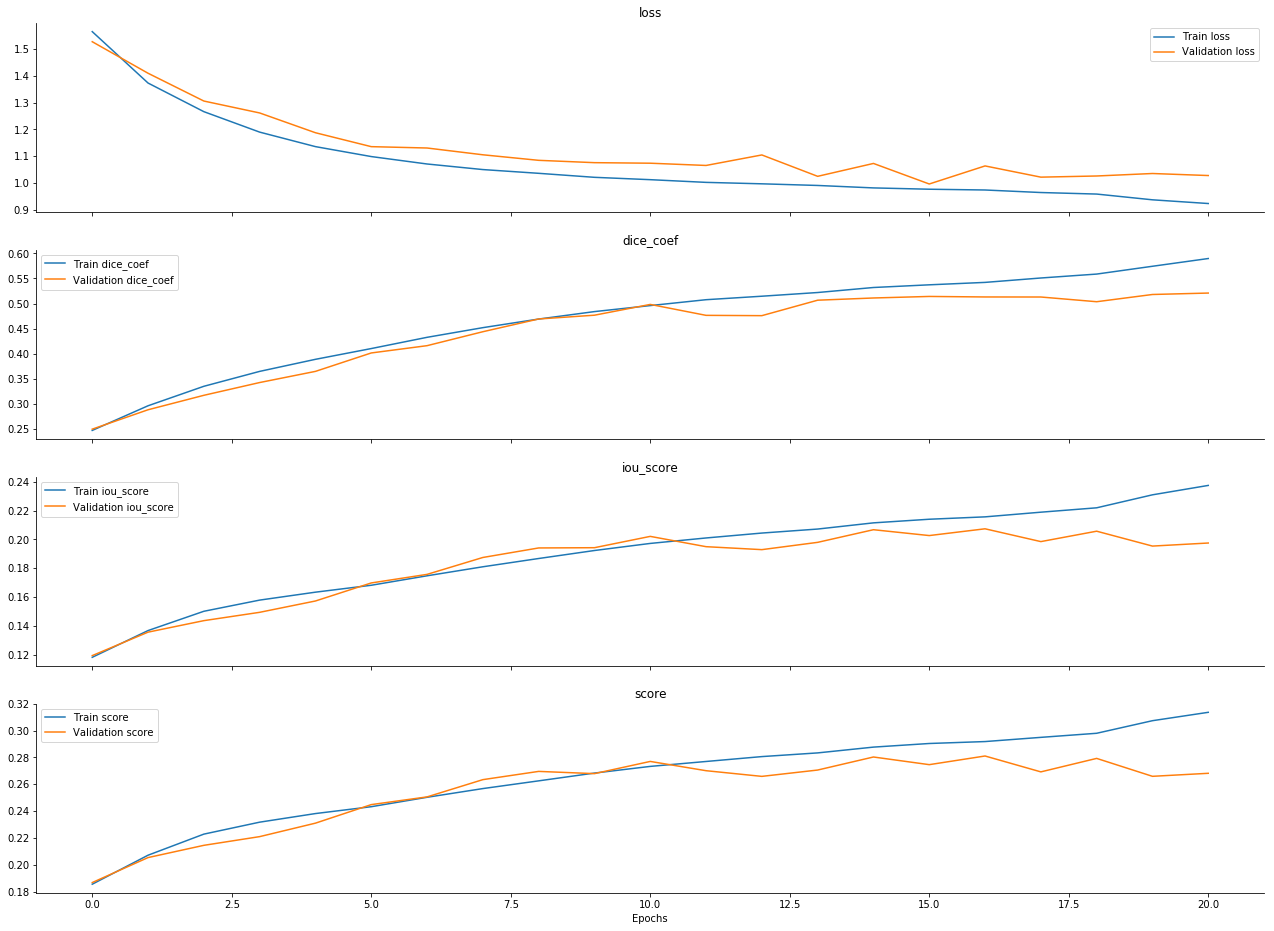

In [8]:
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])